# Notebook for extracting features for authorship attribution.
In this notebook all authorship attribution features will be collected. They will be saved after extraction. Make sure, you define each feature extraction in a function, so it easily can be repurposed.

Author: lkt259@alumni.ku.dk & vsl133@alumni.ku.dk

In [1]:
import numpy as np
import pandas as pd
import re
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
from lexicalrichness import LexicalRichness
from matplotlib import pyplot as plt
import random
import spacy
import os, sys

In [2]:
def rand_emot():
    e = ["(o_o)",":-)",":P",":D","x)","ᓚᘏᗢ","╯°□°）╯︵ ┻━┻",":)",
         "*<:-)","^_^","(⌐■_■)","¯\_(ツ)_/¯", "(T_T)",":o","OwO",
        "( ͡❛ ͜ʖ ͡❛)","(̶◉͛‿◉̶)","( ≖.≖)","(ㆆ_ㆆ)","ʕ•́ᴥ•̀ʔっ","( ◡́.◡̀)","(^◡^ )"]
    return random.choice(e)

#### Sentence length
Nice feature, very complex!

In [3]:
string = "We can work with single sentences (classifying them with respect to sentiment, topic, authorship, etc), or more than one at a time (checking for similarities, contradiction, question/answer pairs, etc.) Another successful application is to encode one sentence in one language and use a different autoencoder to decode it into another language, e.g. Cho et al. (2014)."
train_corpus = ['This list has overlapping features with content features. For example, word n-grams will capture the content of the text along with stylometric tendencies. Content features consist of word frequencies, word and character n-grams, hapax legomena etc. This overlap is not of concern, however, as Sari et al. \cite{Sari2018} show, using content features is beneficial when performing authorship attribution of news articles because journalists often have certain topics they prefer writing about. They argue that using only stylometric features is beneficial when attributing authors to texts of the same topic or genre, e.g. law text or movie reviews.',
              'Bozkurt et al. \cite{Bozkurt} performed authorship attribution on Turkish newspaper articles using stylometric features, vocabulary diversity, bag of words and frequency of function words. For stylometric features, they used number of sentences and words in the article, the average number of words in a sentence and the whole article, the vocabulary size, frequencies of symbols used (periods, exclamation marks, etc.) and the number of incomplete sentences. They weighted their features using Term Frequency-Inverse Document Frequency (TF-IDF).',
              'TF-IDF is a weighting system often used on words. It consists of two parts: term frequency (TF), which coulds how often a term occurs in a document, and inverse document frequency (IDF) which measures the term importance, as it compares how often the term occurs in a corpus\cite{TFIDF}. The system is useful for measuring how important a term is for a document. For example, the word "the" will often occur in English texts, making it not important even though it occurs frequently in a document. TF-IDF has on many occasions been used in authorship attribution\cite{Muttenhaler, basile:2019, rahgouy:2019} and can be used on different terms, such as characters, symbols or n-grams.',
              'Every year, the research group Webis hosts the PAN shared tasks on digital text forensics and sylometry\cite{PAN}. Contestants will solve various tasks concerning NLP and on multiple occasions, authorship attribution were part of the tasks. The methodologies used in these tasks are useful resources for feature and model selections.',
              'In the overview paper of the authorship attribution task of PAN 2019\cite{kestemont2019overview}, the 12 best performing models are compiled. All features involve character n-grams and other sorts of n-grams. Other popular choices of n-grams contain words, POS tags, punctuation and distortion. Most of the participants use TF-IDF weighting and SVMs as classifiers. Distortion is a method for masking topical contents of the text before feature extraction, focusing only on stylometric features.']
test_corpus = ['I have been unable to generate numbers by the Bohr hypothesis, but given more time, I would have simulated multiple distributions following the formula and compare the peak locations to my fit results, by looking at their means and if plausible, perform a t- or z-test to compare. Perhaps using a Kolmogorov-Smirnov test on the entirety of the data would show if it matches only by the peaks or by the whole distribution.',
               "In recent years there have been an increasing interest in biometric identification. Various studies has been conducted aiming to detect individual or unique demographic traits. Results from recent studies have given reason to believe that the ability to predict demographic information using eye tracking is highly dependent on the stimulus. Based on this, this study performs a comparison using two datasets built on different stimulus: IQ tests and passive image viewing. This study found significant differences in the accuracy achieved on the two datasets using a Random Forest (RF) and Long-Short Term Memory network (LSTM) as classifiers. The random forest performed best with an accuracy of 0.85 on the passive image viewing dataset and 0.70 on the IQ dataset. Furthermore, we investigated the effect of using micro movements of the eye as features in the model, which has proven to be a useful feature in recent studies within biometric identification. Lastly, we report the classifiers' ability to perform task independent predictions of gender, using one dataset for training and another for testing. The result from this experiments was not satisfying and close to chance level. However, combining the dataset for training and testing resulted in the random forest having an overall accuracy on the combined dataset of 0.74.",
              ]

In [4]:
def split_sentences(text):
    '''Returns an array with text split into sentences'''
    return np.array(re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text), dtype=str)

def remove_dots(word):
    return re.sub(r',|\.|:|!|\?|;', '', word)

def split_words(text):
    '''Returns an array with text split into words'''
    text = text.lower()
    string = np.array(text.split(), dtype=str)
    no_dot = np.array([remove_dots(x) for x in string])
    return no_dot

def get_sentence_lengths(text):
    '''Returns dictionary with sentence lengh in chars and words'''
    split_text = split_sentences(text)
    num_sentences = len(split_text)
    num_chars = np.array([len(x) for x in split_text], dtype=int)
    num_words = [split_words(x).size for x in split_sentences(string)]
    return {'chars' : num_chars, 'words' : num_words, 'num_sents' : num_sentences}

def get_sentence_length_stats(text):
    '''Returns dictionary with mean, std and median lengths in both chars and words'''
    sentence_lengths = get_sentence_lengths(text)
    output = {'number_of_sentences' : sentence_lengths['num_sents'],
              'avg_sent_len_chars' : np.mean(sentence_lengths['chars']),
              'std_sent_len_chars' : np.std(sentence_lengths['chars']),
              'med_sent_len_chars' : np.median(sentence_lengths['chars']),
              
              'avg_sent_len_words' : np.mean(sentence_lengths['words']),
              'std_sent_len_words' : np.std(sentence_lengths['words']),
              'med_sent_len_words' : np.median(sentence_lengths['words'])
             }
    return output

print("Stats for our test document")
get_sentence_length_stats(string)

Stats for our test document


{'number_of_sentences': 2,
 'avg_sent_len_chars': 183.0,
 'std_sent_len_chars': 176.0,
 'med_sent_len_chars': 183.0,
 'avg_sent_len_words': 28.0,
 'std_sent_len_words': 27.0,
 'med_sent_len_words': 28.0}

##### Word length
The count of words of the entire text.
Also extremely complex feature, cool shit.

In [5]:
def get_word_lengths(split_text):
    '''Returns length of words in characters'''
    return np.array([len(x) for x in split_text], dtype=int)

def get_word_length_stats(text):
    '''Returns various stats for words in document'''
    #Split text here, to reduce function calls.
    split_text = split_words(text)
    word_lengths = get_word_lengths(split_text)
    output = {
        'number_of_words' : len(split_text),
        'avg_word_len_chars' : np.mean(word_lengths),
        'std_word_len_chars' : np.std(word_lengths),
        'med_word_len_chars' : np.median(word_lengths)
    }
    return output

print("Test word lengths")
get_word_length_stats(string)

Test word lengths


{'number_of_words': 56,
 'avg_word_len_chars': 5.339285714285714,
 'std_word_len_chars': 3.4500351225659682,
 'med_word_len_chars': 4.0}

### Word frequency
Get word frequencies with TF-IDF weightings.

Word frequency is the same as word unigrams - defined later.

In [6]:
def get_tfidf_names(vectorizer, X, h=5):
    ngrams = vectorizer.get_feature_names()
    dense = X.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=ngrams)
    display(df.head(h))

### Hapax legomena
Count how many unique words are in a document.

In [7]:
def get_num_hapax(split_text):
    '''Returns the numer of hapax legomena, takes a split words as input'''
    fdist = nltk.probability.FreqDist(split_text)
    return len(fdist.hapaxes())

### Lexical diversity
Compute single-values describing the lexical diversities.

In [8]:
def compute_lix(text):
    tokens = nltk.word_tokenize(text)
    splt = text.split()
    o = len(splt)+1
    p = len([x for x in tokens if x=='.'])+1
    l = len([x for x in tokens if len(x)>6])+1
    
    return (o/p)+((l*100)/o)

def lexical_diversities(text):
    '''Returns a dictionary with various vocabulary richness measures'''
    lex = LexicalRichness(text, tokenizer=split_words)
    output = {
        'ttr' : lex.ttr,
        'rttr' : lex.rttr,
        'cttr' : lex.cttr,
        'herdan' : lex.Herdan,
        'summer' : lex.Summer,
        'dugast' : lex.Dugast,
        'maas' : lex.Maas,
        'lix' : compute_lix(text)
    }
    return output

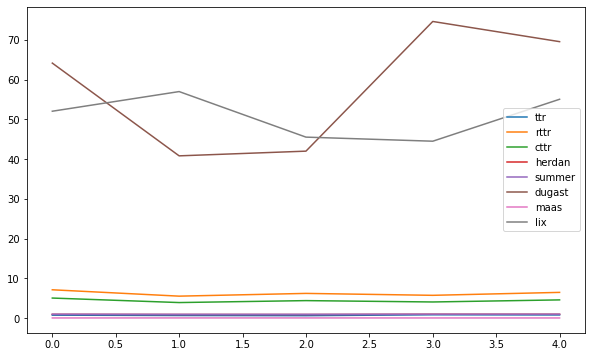

In [9]:
stats = [lexical_diversities(x) for x in train_corpus]

ttr = [x['ttr'] for x in stats]
rttr = [x['rttr'] for x in stats]
cttr = [x['cttr'] for x in stats]
herdan = [x['herdan'] for x in stats]
summer = [x['summer'] for x in stats]
dugast = [x['dugast'] for x in stats]
maas = [x['maas'] for x in stats]
lix = [x['lix'] for x in stats]

fig = plt.figure(figsize=(10,6))
plt.plot(ttr, label='ttr')
plt.plot(rttr, label='rttr')
plt.plot(cttr, label='cttr')
plt.plot(herdan, label='herdan')
plt.plot(summer, label='summer')
plt.plot(dugast, label='dugast')
plt.plot(maas, label='maas')
plt.plot(lix, label='lix')
plt.legend()

# N-Grams
A collection of vectorizers for different types of n-grams.

In [10]:
POS_tagger_DK = spacy.load("da_core_news_md")

In [11]:
def word_ngram_vectorizer(train_corpus, n): 
    #Trains a TF-IDF vectorizer of word n-grams
    vectorizer = TfidfVectorizer(max_features=3000, analyzer="word", ngram_range=(n,n))
    print(f"Training word {n}-gram vectorizer...",rand_emot())
    
    X = vectorizer.fit_transform(train_corpus)
    print("Vectorizer fit!", rand_emot())
    
    return X, vectorizer

def char_ngram_vectorizer(train_corpus, n): 
    #Trains a TF-IDF vectorizer of character n-grams
    vectorizer = TfidfVectorizer(max_features=3000, analyzer="char", ngram_range=(n,n))
    print(f"Training char {n}-gram vectorizer...",rand_emot())
    
    X = vectorizer.fit_transform(train_corpus)
    print("Vectorizer fit!", rand_emot())
      
    return X, vectorizer

def POS_ngram_vectorizer(train_corpus, n): 
    #Trains a TF-IDF vectorizer of POS n-grams. A POS corpus is generated in the function using a tagger for Danish.
    #Create POS corpus
    POS_corpus = []

    for doc in train_corpus:
        tagged_doc = POS_tagger_DK(doc) #tag each document in corpus with POS tags using spacy
        POS_list = []

        for token in tagged_doc:
            POS_list.append(token.pos_)

        #concatenate as POS tags for the document
        POS_text = " ".join(POS_list)
        POS_corpus.append(POS_text)

    
    vectorizer = TfidfVectorizer(max_features=3000, analyzer="word", ngram_range=(n,n))
    print(f"Training POS {n}-gram vectorizer...",rand_emot())
    
    X = vectorizer.fit_transform(POS_corpus)
    print("Vectorizer fit!", rand_emot())

    return X, vectorizer

In [12]:
# Gets weights for terms based on trained vectorizer
# Works for both word and character ngrams
def get_tfidf_ngrams(vectorizer, test_corpus):
    '''Returns the TF-IDF weighted ngram frequencies of test documents'''
    #Multiple texts required
    return vectorizer.transform(test_corpus)

# Function generates POS test corpus first and then gets weights for terms based on trained vectorizer. 
def get_tfidf_POS_ngrams(vectorizer, test_corpus):
    '''Returns the TF-IDF weighted ngram frequencies of test documents'''
    #Create POS corpus
    POS_corpus = []

    for doc in test_corpus:
        tagged_doc = POS_tagger_DK(doc) #tag each document in corpus with POS tags using spacy
        POS_list = []

        for token in tagged_doc:
            POS_list.append(token.pos_)

        #concatenate POS tags as one string, i.e. the documented represented as the POS tags
        POS_text = " ".join(POS_list)
        POS_corpus.append(POS_text)
    
    #Multiple texts required
    return vectorizer.transform(POS_corpus)

In [13]:
%%capture
def train_vectorizers(training_data):
    '''Returns 2 dictionaries: vectorizers and weights
    Only use this function on training data'''
    
    X_word_unigrams, unigram_word_vectorizer = word_ngram_vectorizer(training_data, 1)
    X_word_bigrams, bigram_word_vectorizer = word_ngram_vectorizer(training_data, 2)
    X_word_trigrams, trigram_word_vectorizer = word_ngram_vectorizer(training_data, 3)
    
    X_char_unigrams, unigram_char_vectorizer = char_ngram_vectorizer(training_data, 1)
    X_char_bigrams, bigram_char_vectorizer = char_ngram_vectorizer(training_data, 2)
    X_char_trigrams, trigram_char_vectorizer = char_ngram_vectorizer(training_data, 3)
    
    X_POS_unigrams, unigram_POS_vectorizer = POS_ngram_vectorizer(training_data, 1)
    X_POS_bigrams, bigram_POS_vectorizer = POS_ngram_vectorizer(training_data, 2)
    X_POS_trigrams, trigram_POS_vectorizer = POS_ngram_vectorizer(training_data, 3)
    
    
    vectorizers = {
        'uni_word' : unigram_word_vectorizer,
        'bi_word' : bigram_word_vectorizer,
        'tri_word' : trigram_word_vectorizer,
        'uni_char' : unigram_char_vectorizer,
        'bi_char' : bigram_char_vectorizer,
        'tri_char' : trigram_char_vectorizer,
        'uni_pos' : unigram_POS_vectorizer,
        'bi_pos' : bigram_POS_vectorizer,
        'tri_pos' : trigram_POS_vectorizer,
    }
    
    weights = {
        'uni_word' : X_word_unigrams,
        'bi_word' : X_word_bigrams,
        'tri_word' : X_word_trigrams,
        'uni_char' : X_char_unigrams,
        'bi_char' : X_char_bigrams,
        'tri_char' : X_char_trigrams,
        'uni_pos' : X_POS_unigrams,
        'bi_pos' : X_POS_bigrams,
        'tri_pos' : X_POS_trigrams,
    }
    
    return vectorizers, weights

vectorizers, weights = train_vectorizers(train_corpus)

In [14]:
get_tfidf_names(vectorizers['uni_word'], weights['uni_word'])

,12,2019,about,al,all,along,and,are,argue,article,...,were,when,which,whole,will,with,word,words,writing,year
0,0.000000,0.000000,0.091857,0.074110,0.000000,0.091857,0.043770,0.000000,0.091857,0.000000,...,0.000000,0.183714,0.000000,0.000000,0.061518,0.183714,0.222329,0.000000,0.091857,0.000000
1,0.000000,0.000000,0.000000,0.083392,0.000000,0.000000,0.197010,0.000000,0.000000,0.206724,...,0.000000,0.000000,0.000000,0.103362,0.000000,0.000000,0.000000,0.276891,0.000000,0.000000
2,0.000000,0.126477,0.000000,0.000000,0.000000,0.000000,0.074699,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.156765,0.000000,0.052494,0.000000,0.063239,0.052494,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.194620,0.109840,0.000000,0.000000,...,0.136144,0.000000,0.000000,0.000000,0.091177,0.000000,0.000000,0.000000,0.000000,0.136144
4,0.120723,0.097399,0.000000,0.000000,0.120723,0.000000,0.172576,0.097399,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080850,0.000000,0.000000


### Combining features
Combine the features into one long as fuck vector!

In [15]:
def vectorize_test_data(vectorizers, test_data):
    '''Returns weighted matrices for test data.'''
    weights = {}
    for vectorizer in vectorizers:
        if 'pos' in vectorizer:
            weights[vectorizer] = get_tfidf_POS_ngrams(vectorizers[vectorizer], test_data)
        else:
            weights[vectorizer] = get_tfidf_ngrams(vectorizers[vectorizer], test_data)
    return weights
    

def combine_data(data, train_test, vectorizers=None):
    #Trains vectorizers if training data is specified.
    if train_test == 'train':
        assert vectorizers == None, "Please do not specify vectorizers when training them!"
        print("Training data specified... Training vectorizers!\n")
        vectorizers, weights = train_vectorizers(data)
    elif train_test == 'test':
        assert type(vectorizers) == dict, "Vectorizers need to be in a dict!"
        print("Test data being vectorized...")
        weights = vectorize_test_data(vectorizers, data)
    else:
        print("Please specify type of data!")
        return
    
    #Stack ngrams
    word_ngrams = np.hstack((weights['uni_word'].todense(), weights['bi_word'].todense(), weights['tri_word'].todense()))
    char_ngrams = np.hstack((weights['uni_char'].todense(), weights['bi_char'].todense(), weights['tri_char'].todense()))
    pos_ngrams = np.hstack((weights['uni_pos'].todense(), weights['bi_pos'].todense(), weights['tri_pos'].todense()))
    ngrams = np.hstack((word_ngrams, char_ngrams, pos_ngrams))
    print()
    print("N-grams shape:", ngrams.shape)
    
    #Stack scalar features
    sentence_stats = [list(get_sentence_length_stats(x).values()) for x in data]
    word_stats = [list(get_word_length_stats(x).values()) for x in data]
    lexical_diversity = [list(lexical_diversities(x).values()) for x in data]
    hapax = [[get_num_hapax(x)] for x in data]
    scalars = np.hstack((sentence_stats, word_stats, lexical_diversity,hapax))
    print("Scalars shape:", scalars.shape)
    
    return np.hstack((ngrams, scalars)), vectorizers
    

# Test some models
Not final models, but just to see how everything works.

In [16]:
#Load a subset of the data
with open('data/additional/scraped/data_30.json') as f:
    dataframe = pd.read_json(f)
    
train1 = dataframe.loc[(dataframe["Byline"] == "Magnus Boye")][:10]
train2 = dataframe.loc[(dataframe["Byline"] == "Morten Guldberg")][:10]
train3 = dataframe.loc[(dataframe["Byline"] == "Alexander Bitsch")][:10]
train4 = dataframe.loc[(dataframe["Byline"] == "Morten Bjerregaard")][:10]
train5 = dataframe.loc[(dataframe["Byline"] == "Silla Bakalus")][:10]

frames = [train1, train2,train3, train4, train5]
trainset = pd.concat(frames, sort=False)
bodies = list(trainset["Body"])
authors = list(trainset["Byline"])

train_X, test_X, train_y, test_y = train_test_split(bodies, authors, test_size=0.2, random_state=42, stratify=authors)

#Convert names to categories
le = LabelEncoder()
train_y = le.fit_transform(train_y)
test_y = le.fit_transform(test_y)

train_X, vectorizers = combine_data(train_X, 'train')
test_X, _ = combine_data(test_X, 'test', vectorizers=vectorizers)

Training data specified... Training vectorizers!

Training word 1-gram vectorizer... (ㆆ_ㆆ)
Vectorizer fit! x)
Training word 2-gram vectorizer... :D
Vectorizer fit! ʕ•́ᴥ•̀ʔっ
Training word 3-gram vectorizer... (^◡^ )
Vectorizer fit! *<:-)
Training char 1-gram vectorizer... :D
Vectorizer fit! ╯°□°）╯︵ ┻━┻
Training char 2-gram vectorizer... (^◡^ )
Vectorizer fit! (̶◉͛‿◉̶)
Training char 3-gram vectorizer... ( ͡❛ ͜ʖ ͡❛)
Vectorizer fit! ʕ•́ᴥ•̀ʔっ
Training POS 1-gram vectorizer... :)
Vectorizer fit! ╯°□°）╯︵ ┻━┻
Training POS 2-gram vectorizer... (o_o)
Vectorizer fit! :-)
Training POS 3-gram vectorizer... ¯\_(ツ)_/¯
Vectorizer fit! :o

N-grams shape: (40, 14818)
Scalars shape: (40, 20)
Test data being vectorized...

N-grams shape: (10, 14818)
Scalars shape: (10, 20)


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn import preprocessing

lrg = LogisticRegression(max_iter=100, n_jobs=2)
lrg.fit(train_X, train_y)
f1_score(test_y, lrg.predict(test_X), average='weighted')

0.26666666666666666

In [18]:
import classifier_unit_test
tpr, fpr, dum_tpr, dum_fpr = classifier_unit_test.test_classifier(lrg, train_X, test_X, train_y, test_y, give_roc=True)

Oh, model already fit. Thanks!
Training dummy...
Correctly predicted 3 of 10	Dummy: 2 of 10	:-)
Accuracy: 0.30			Dummy: 0.20	:-)
Balanced accuracy: 0.30		Dummy: 0.20	:-)
F1 score: 0.27			Dummy: 0.07	:-)
ROC AUC: 0.69			Dummy: 0.50	:-)


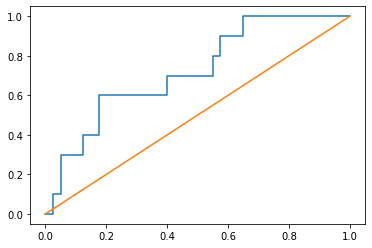

In [26]:
plt.plot(tpr,fpr)
plt.plot(dum_tpr, dum_fpr)

In [29]:
from sklearn.inspection import permutation_importance

In [31]:
r = permutation_importance(lrg, test_X, test_y)

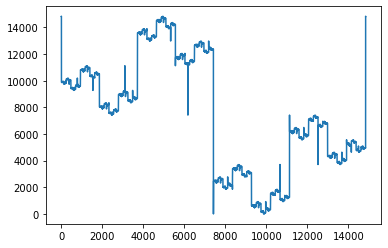

In [41]:
plt.plot(r.importances_mean.argsort())

In [42]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(r.importances_mean[i], r.importances_std[i])

0.13999999999999996 0.048989794855663564
0.09999999999999998 0.0
